In [72]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# import tensorflow as tf
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import random
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
warnings.filterwarnings(action='ignore')
warnings.resetwarnings()

In [73]:
movies_dat = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, names=["MovieID", "Title", "Genres"], engine='python')
movies_dat['movie_index'] = movies_dat.index
movies_dat.head(n=10)

,MovieID,Title,Genres,movie_index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4
5,6,Heat (1995),Action|Crime|Thriller,5
6,7,Sabrina (1995),Comedy|Romance,6
7,8,Tom and Huck (1995),Adventure|Children's,7
8,9,Sudden Death (1995),Action,8
9,10,GoldenEye (1995),Action|Adventure|Thriller,9


In [74]:
ratings_dat = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')
ratings_dat.head(n=10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [75]:
users_dat = pd.read_csv('ml-1m/users.dat', sep='::', header=None, names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], engine='python')
users_dat.head(n=10)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [76]:
print('# of movies in csv = ', len(movies_dat))
print('# of ratings in csv = ', len(ratings_dat))
print('# of users in csv = ', len(users_dat))

# of movies in csv =  3883
# of ratings in csv =  1000209
# of users in csv =  6040


In [77]:
movies_ratings_merge_movieID = movies_dat.merge(ratings_dat, on='MovieID')
movies_ratings_merge_movieID = movies_ratings_merge_movieID.drop('Timestamp', axis=1)
movies_ratings_merge_movieID.head(n=10)

,MovieID,Title,Genres,movie_index,UserID,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,0,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,0,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,0,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,0,10,5
5,1,Toy Story (1995),Animation|Children's|Comedy,0,18,4
6,1,Toy Story (1995),Animation|Children's|Comedy,0,19,5
7,1,Toy Story (1995),Animation|Children's|Comedy,0,21,3
8,1,Toy Story (1995),Animation|Children's|Comedy,0,23,4
9,1,Toy Story (1995),Animation|Children's|Comedy,0,26,3


In [78]:
#this table is the same as the table above, because groupby is used but no action is specified
movies_ratings_groupby_userID = movies_ratings_merge_movieID.groupby('UserID')
movies_ratings_groupby_userID.head(n=10)

,MovieID,Title,Genres,movie_index,UserID,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,0,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,0,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,0,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,0,10,5
...,...,...,...,...,...,...
992806,3897,Almost Famous (2000),Comedy|Drama,3827,1226,2
994331,3911,Best in Show (2000),Comedy,3841,986,5
994824,3912,Beautiful (2000),Comedy|Drama,3842,986,1
994905,3914,"Broken Hearts Club, The (2000)",Drama,3844,986,3


In [79]:
nTrain_users = int(len(users_dat)*0.8)
print(nTrain_users)
total = []
for UserID, user in movies_ratings_groupby_userID:
    movie_rating_db = np.zeros(len(movies_dat))
    for num, movie in user.iterrows():
        movie_rating_db[movie['movie_index']] = movie['Rating']/5.0
    total.append(movie_rating_db)
    
random.shuffle(total)
train = total[:nTrain_users]
valid = total[nTrain_users:]

4832


In [80]:
hiddenUnits = 20
visibleUnits = len(movies_dat)

# Number of unique movies
vb = tf.placeholder(tf.float32, [visibleUnits])

# Number of features that we are going to learn
hb = tf.placeholder(tf.float32, [hiddenUnits])  
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])

v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb) 
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

# Hidden layer activation
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

# Learning rate
alpha = 0.6

# Creating the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], dtype=tf.float32)

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)

# Running the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [81]:
def free_energy(v_sample, W, vb, hb):
    ''' Function to compute the free energy '''
    wx_b = np.dot(v_sample, W) + hb
    vbias_term = np.dot(v_sample, vb)
    hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis = 1)
    return -hidden_term - vbias_term

In [82]:
epochs = 15
batchsize = 100
errors = []
energy_train = []
energy_valid = []
for i in range(epochs):
    for start, end in zip(range(0, len(train), batchsize), range(batchsize, len(train), batchsize)):
        batch = train[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        
    energy_train.append(np.mean(free_energy(train, cur_w, cur_vb, cur_hb)))
    energy_valid.append(np.mean(free_energy(valid, cur_w, cur_vb, cur_hb)))
        
    errors.append(sess.run(err_sum, feed_dict={v0: train, W: cur_w, vb: cur_vb, hb: cur_hb}))
    
#     if i % 10 == 0:
    print("Error in epoch {0} is: {1}".format(i, errors[i]))
    
#     print(errors[-1])

Error in epoch 0 is: 0.054975952953100204
Error in epoch 1 is: 0.04584550857543945
Error in epoch 2 is: 0.043488066643476486
Error in epoch 3 is: 0.04221411421895027
Error in epoch 4 is: 0.04168412461876869
Error in epoch 5 is: 0.04118139296770096
Error in epoch 6 is: 0.040758658200502396
Error in epoch 7 is: 0.040382057428359985
Error in epoch 8 is: 0.040037237107753754
Error in epoch 9 is: 0.03996815159916878
Error in epoch 10 is: 0.03960152342915535
Error in epoch 11 is: 0.0394151471555233
Error in epoch 12 is: 0.0392923541367054
Error in epoch 13 is: 0.039241090416908264
Error in epoch 14 is: 0.039074525237083435


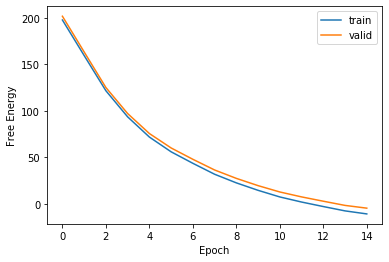

In [83]:
fig, ax = plt.subplots()
ax.plot(energy_train, label='train')
ax.plot(energy_valid, label='valid')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Free Energy")
plt.savefig("free_energy.png")
plt.show()

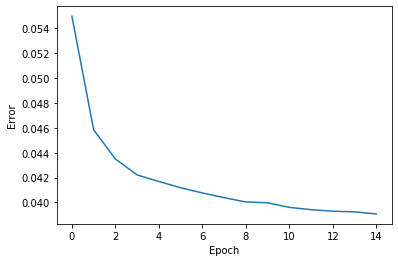

In [84]:
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.savefig("error.png")
plt.show()

In [85]:
user = 30
inputUser = [train[user]]

In [86]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [106]:
model_score_movies_dat = movies_dat
model_score_movies_dat["Recommendation Score"] = rec[0]
model_score_movies_dat = model_score_movies_dat.sort_values(["Recommendation Score"], ascending=False)
model_score_movies_dat.sort_values(["Recommendation Score"], ascending=False).head(10)

,MovieID,Title,Genres,movie_index,Recommendation Score
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.779820
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,912,0.777520
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War,740,0.708569
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.682075
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.666584
3402,3471,Close Encounters of the Third Kind (1977),Drama|Sci-Fi,3402,0.664518
523,527,Schindler's List (1993),Drama|War,523,0.660030
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.658341
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller,1232,0.632275
31,32,Twelve Monkeys (1995),Drama|Sci-Fi,31,0.627914


In [107]:
print(len(model_score_movies_dat))

3883


In [108]:
print(movies_ratings_merge_movieID.iloc[user])

cur_userID = ratings_dat.iloc[user]['UserID']
print("\ncurrent user:", cur_userID)

MovieID                                  1
Title                     Toy Story (1995)
Genres         Animation|Children's|Comedy
movie_index                              0
UserID                                  96
Rating                                   4
Name: 30, dtype: object

current user: 1


In [109]:
watched_movies = ratings_dat[ratings_dat['UserID'] == cur_userID]['MovieID']
print("\nwatched movies: ", len(watched_movies))
watched_movies.head(n=53)


watched movies:  53


0     1193
1      661
2      914
3     3408
4     2355
5     1197
6     1287
7     2804
8      594
9      919
10     595
11     938
12    2398
13    2918
14    1035
15    2791
16    2687
17    2018
18    3105
19    2797
20    2321
21     720
22    1270
23     527
24    2340
25      48
26    1097
27    1721
28    1545
29     745
30    2294
31    3186
32    1566
33     588
34    1907
35     783
36    1836
37    1022
38    2762
39     150
40       1
41    1961
42    1962
43    2692
44     260
45    1028
46    1029
47    1207
48    2028
49     531
50    3114
51     608
52    1246
Name: MovieID, dtype: int64

In [110]:
to_watch_with_repeats = ratings_dat[~ratings_dat['MovieID'].isin(watched_movies)]
to_watch_with_repeats.head(n=10)
print(len(to_watch_with_repeats))

940010


In [111]:
# source_to_watch_with_repeats = pd.DataFrame(to_watch_with_repeats)

# # keep first duplicate row
to_watch = to_watch_with_repeats.drop_duplicates(subset='MovieID', keep="first")
print(to_watch.head(n=30))
print(len(to_watch))



    UserID  MovieID  Rating  Timestamp
53       2     1357       5  978298709
54       2     3068       4  978299000
55       2     1537       4  978299620
56       2      647       3  978299351
57       2     2194       4  978299297
58       2      648       4  978299913
59       2     2268       5  978299297
60       2     2628       3  978300051
61       2     1103       3  978298905
62       2     2916       3  978299809
63       2     3468       5  978298542
64       2     1210       4  978298151
65       2     1792       3  978299941
66       2     1687       3  978300174
67       2     1213       2  978298458
68       2     3578       5  978298958
69       2     2881       3  978300002
70       2     3030       4  978298434
71       2     1217       3  978298151
73       2      434       2  978300174
74       2     2126       3  978300123
75       2     3107       2  978300002
76       2     3108       3  978299712
77       2     3035       4  978298625
78       2     1253      

In [115]:
count = 0
top_movies = model_score_movies_dat['MovieID'].tolist()
# print(top_movies)
to_watch_movies = to_watch['MovieID'].tolist()
# print(to_watch_movies)


recommendation_movieID = []
for movieID in top_movies:
    if movieID in to_watch_movies:
        recommendation_movieID.append(movieID)
        count += 1
    if count == 10:
        break

In [116]:
recommendation = movies_dat[movies_dat['MovieID'].isin(recommendation_movieID)]
recommendation = recommendation.sort_values(["Recommendation Score"], ascending=False)

recommendation.head(n=10)

,MovieID,Title,Genres,movie_index,Recommendation Score
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,912,0.777520
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War,740,0.708569
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.666584
3402,3471,Close Encounters of the Third Kind (1977),Drama|Sci-Fi,3402,0.664518
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.658341
1232,1252,Chinatown (1974),Film-Noir|Mystery|Thriller,1232,0.632275
31,32,Twelve Monkeys (1995),Drama|Sci-Fi,31,0.627914
537,541,Blade Runner (1982),Film-Noir|Sci-Fi,537,0.626744
900,912,Casablanca (1942),Drama|Romance|War,900,0.611151
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,1220,0.607181
